<a href="https://colab.research.google.com/github/erickdiaz3010/tesis-network-analysis/blob/main/Thesis_VA_in_CA_Erick.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Mounting with Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# STEP 1 : Loading Input-Output Data and Setting Index for Sectoral Analysis
#This step loads all the necessary **Input-Output tables** from the Excel file and ensures that the `"code"` column is correctly set as the index.
# This process aligns sectoral data across different DataFrames to maintain consistency in later calculations.
# The key datasets include **Intermediate Consumption (`Z`), Gross Production (`T`), and Domestic Value Added (`C_df`)**.


import pandas as pd
import numpy as np

# Define the file path
file_path = "/content/drive/MyDrive/Thesis/thesis/Paper input output/data/real/CA IO table 2014 - real.xlsx"

# Load all sheets into a dictionary of DataFrames
all_sheets = pd.read_excel(file_path, sheet_name=None)

# Standardize all DataFrames: Ensure 'code' is the index and remove extra 'code' column
for sheet_name, df in all_sheets.items():
    if 'code' in df.columns:
        df.set_index('code', inplace=True)  # Set 'code' as index
    # Ensure no extra 'code' column remains
    if 'code' in df.columns:
        df.drop(columns=['code'], inplace=True)
    all_sheets[sheet_name] = df  # Save changes back

print("✅ All DataFrames have been standardized with 'code' as index.")

# Extract DataFrames
Z = all_sheets.get('Intermediate_Consumption_Z')
T = all_sheets.get('Gross_Production_Value')
C_df = all_sheets.get('Domestic_Value_added')

# Debugging: Print initial shape
print("\n📊 Shapes after processing:")
for name, df in all_sheets.items():
    print(f"{name}: {df.shape}")

# Ensure correct columns
if 'Gross_Production_Value' in T.columns:
    T = T[['Gross_Production_Value']]  # Keep only the relevant column





✅ All DataFrames have been standardized with 'code' as index.

📊 Shapes after processing:
LAC_IOT_2014: (2205, 251)
original: (244, 251)
Intermediate_Consumption_Z: (240, 240)
Final_Demand_Intraregional: (240, 6)
Extra_Regional_Imports: (240, 37)
Production_Taxes: (240, 1)
Freight_Insurance: (240, 1)
Domestic_Value_added: (240, 1)
Gross_Production_Value: (240, 1)
Value_Added_Coefficients: (240, 2)
Adjacency_Matrix: (240, 241)
Leontief_Inverse: (240, 241)
GVAN Matrix (G): (240, 241)
IVAN Matrix (Y): (240, 241)


In [ ]:
# STEP 2: Constructing the Adjacency Matrix (A) and Computing the Leontief Inverse Matrix (L).
# This step constructs the **Adjacency Matrix (A)**, which represents sectoral interdependencies based on **Intermediate Consumption (`Z`) and Gross Production (`T`)**.
# The matrix **A is used to compute the Leontief Inverse Matrix (L)**, which measures the total economic impact of demand shocks.
# The successful inversion of **(I - A)** ensures that the model is mathematically well-defined and can be used for economic impact analysis.

def create_adjacency_matrix(Z, T):
    """Compute the adjacency matrix A from Intermediate Consumption and Gross Production Value matrices."""

    # Ensure 'code' is the index
    if 'code' in Z.columns:
        Z.set_index('code', inplace=True)
    if 'code' in T.columns:
        T.set_index('code', inplace=True)

    # Ensure Z and T are aligned and square
    Z = Z.loc[Z.index.intersection(T.index), Z.columns.intersection(T.index)]
    T = T.loc[T.index.intersection(Z.index)]

    # Convert data to numeric
    Z = Z.apply(pd.to_numeric, errors='coerce')
    T['Gross_Production_Value'] = pd.to_numeric(T['Gross_Production_Value'], errors='coerce')

    # Extract the production vector and avoid division by zero
    T_vector = T['Gross_Production_Value'].fillna(1e-10).values
    epsilon = 1e-10
    T_vector = np.where(T_vector == 0, epsilon, T_vector)

    # Convert to matrix form
    Z_matrix = Z.fillna(0).values

    # Compute adjacency matrix A
    A_matrix = np.divide(Z_matrix, T_vector[:, np.newaxis], where=T_vector[:, np.newaxis] != 0)

    return pd.DataFrame(A_matrix, index=Z.index, columns=Z.columns)

# Generate adjacency matrix
A_df = create_adjacency_matrix(Z, T)

# Ensure matrix is square
A_df = A_df.loc[A_df.index.intersection(A_df.columns), A_df.columns.intersection(A_df.index)]

# Save adjacency matrix
with pd.ExcelWriter(file_path, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
    A_df.to_excel(writer, sheet_name="Adjacency_Matrix")

print("✅ Adjacency matrix has been successfully saved.")







✅ Adjacency matrix has been successfully saved.


In [ ]:
# STEP #3: Compute the Leontief Inverse Matrix (L)

import pandas as pd
import numpy as np

# Define the file path
file_path = "/content/drive/MyDrive/Thesis/thesis/Paper input output/data/real/CA IO table 2014 - real.xlsx"

# Load all sheets from Excel
sheets = pd.read_excel(file_path, sheet_name=None)

# Ensure 'Adjacency_Matrix' is present
if "Adjacency_Matrix" not in sheets:
    raise KeyError("❌ Error: 'Adjacency_Matrix' not found. Ensure Step 2 was executed correctly.")

# Load the Adjacency Matrix
A_df = pd.read_excel(file_path, sheet_name="Adjacency_Matrix", index_col=0)  # 🔹 Set first column as index!

# 🔹 Debugging: Check initial dimensions
print("✅ Adjacency Matrix loaded successfully.")
print("📊 Initial Shape of A_df:", A_df.shape)

# Ensure the matrix is square (240x240)
if A_df.shape[1] == 241:
    print("⚠️ Detected an extra column. Dropping the first column to ensure a 240x240 matrix.")
    A_df = A_df.iloc[:, 1:]  # 🔹 Remove the first column if necessary

# 🚨 **Debugging: Check dimensions after ensuring square matrix**
print("📊 Shape of A_df after ensuring it's square:", A_df.shape)

# 🚨 **Check column names before proceeding**
print("🔍 First 5 columns:", A_df.columns[:5].tolist())
print("🔍 Last 5 columns:", A_df.columns[-5:].tolist())

# Verify that the shape is correct before computing the inverse
if A_df.shape != (240, 240):
    raise ValueError(f"❌ Error: Adjacency matrix A is not 240x240. Found shape: {A_df.shape}")

# Compute Leontief Inverse (L = (I - A)^(-1))
I_matrix = np.identity(A_df.shape[0])
I_minus_A = I_matrix - A_df.values

try:
    L_matrix = np.linalg.inv(I_minus_A)
    print("✅ Leontief inverse matrix computed successfully.")
except np.linalg.LinAlgError:
    raise ValueError("❌ Error: The matrix (I - A) is singular and cannot be inverted.")

# Convert to DataFrame for saving
L_df = pd.DataFrame(L_matrix, index=A_df.index, columns=A_df.columns)

# 🚨 **Debugging: Check dimensions before saving**
print("✅ Leontief Inverse Matrix shape:", L_df.shape)

# Save to Excel, replacing previous results
with pd.ExcelWriter(file_path, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
    L_df.to_excel(writer, sheet_name="Leontief_Inverse")

print("✅ Leontief inverse matrix has been successfully saved in Google Sheet.")






✅ Adjacency Matrix loaded successfully.
📊 Initial Shape of A_df: (240, 240)
📊 Shape of A_df after ensuring it's square: (240, 240)
🔍 First 5 columns: ['CRIs01', 'CRIs02', 'CRIs03', 'CRIs04', 'CRIs05']
🔍 Last 5 columns: ['PANs36', 'PANs37', 'PANs38', 'PANs39', 'PANs40']
✅ Leontief inverse matrix computed successfully.
✅ Leontief Inverse Matrix shape: (240, 240)
✅ Leontief inverse matrix has been successfully saved in Google Sheet.


In [ ]:
# Step 4: Calculate the  Value-Added Coefficients Vector (C)

import pandas as pd
import numpy as np

# Define the file path
file_path = "/content/drive/MyDrive/Thesis/thesis/Paper input output/data/real/CA IO table 2014 - real.xlsx"

# Load the required sheets
sheets = pd.read_excel(file_path, sheet_name=None)

# Ensure required sheets are present
if "Domestic_Value_added" not in sheets or "Gross_Production_Value" not in sheets:
    raise KeyError("❌ Error: Required sheets 'Domestic_Value_added' or 'Gross_Production_Value' not found.")

# Load the necessary data
Domestic_Value_Added = sheets["Domestic_Value_added"]
Gross_Production_Value = sheets["Gross_Production_Value"]

# Ensure the columns exist
if 'Domestic_Value_added' not in Domestic_Value_Added.columns or 'Gross_Production_Value' not in Gross_Production_Value.columns:
    raise KeyError("❌ Error: Missing required columns in the dataset.")

# Replace zero values in Gross Production Value to avoid division by zero
epsilon = 1e-10
T_vector = Gross_Production_Value['Gross_Production_Value'].values
T_vector = np.where(T_vector == 0, epsilon, T_vector)  # Replace 0s to avoid NaN

# Compute C_vector
C_vector = Domestic_Value_Added['Domestic_Value_added'].values / T_vector

# Convert to DataFrame and align index
C_df = pd.DataFrame(C_vector, index=Domestic_Value_Added.index, columns=['C'])

# 🚨 **Verificar dimensiones antes de guardar**
print("\n✅ Computed Value-Added Coefficients Vector (C) successfully!")
print("📊 Shape of C_df:", C_df.shape)

# Ensure consistency with Adjacency Matrix indices
if "Adjacency_Matrix" in sheets:
    A_df = sheets["Adjacency_Matrix"]
    C_df = C_df.reindex(A_df.index)

# 🚨 **Verificar que el tamaño de C sea 240x1**
if C_df.shape != (240, 1):
    raise ValueError(f"❌ Error: C_vector shape is incorrect. Found {C_df.shape}, expected (240, 1).")

# Save the computed C_vector to the Excel file
with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists="replace") as writer:
    C_df.to_excel(writer, sheet_name="Value_Added_Coefficients")

print("✅ Value-Added Coefficients Vector (C) has been successfully saved in Google Sheet.")



✅ Computed Value-Added Coefficients Vector (C) successfully!
📊 Shape of C_df: (240, 1)
✅ Value-Added Coefficients Vector (C) has been successfully saved in Google Sheet.


In [ ]:
# STEP 5: Compute the GVAN (G) and IVAN (Y) Matrices for Value-Added Trade Analysis
# This step calculates the **GVAN (`G`) and IVAN (`Y`) matrices**, which quantify how **value-added flows through international trade**.

import pandas as pd
import numpy as np

# Define the file path
file_path = "/content/drive/MyDrive/Thesis/thesis/Paper input output/data/real/CA IO table 2014 - real.xlsx"

# Load only the required sheets
L_df = pd.read_excel(file_path, sheet_name="Leontief_Inverse", index_col=0)
C_df = pd.read_excel(file_path, sheet_name="Value_Added_Coefficients", index_col=0)
T_df = pd.read_excel(file_path, sheet_name="Gross_Production_Value", index_col=0)

# 🚨 **Verificar dimensiones antes de cálculos**
print("\n🔍 Initial Matrix Dimensions:")
print("Leontief Inverse Matrix (L):", L_df.shape)
print("Value-Added Coefficients (C):", C_df.shape)
print("Gross Production Value (T):", T_df.shape)

# ✅ **Ensure dimensions are correct**
if L_df.shape != (240, 240):
    raise ValueError(f"❌ Error: Leontief Inverse matrix has incorrect shape: {L_df.shape}")
if C_df.shape[1] != 1:
    raise ValueError(f"❌ Error: Value-Added Coefficients Vector (C) has incorrect shape: {C_df.shape}")
if T_df.shape[1] != 1:
    raise ValueError(f"❌ Error: Gross Production Value vector (T) has incorrect shape: {T_df.shape}")

# Convert DataFrames to NumPy arrays
C_vector = C_df.values.flatten()  # Convertir a vector 1D
T_vector = T_df.values.flatten()

# ✅**Check before building diagonal matrices**
print("\n🔍 Vector Dimensions:")
print("C_vector shape:", C_vector.shape)
print("T_vector shape:", T_vector.shape)

# Convert C and T into diagonal matrices
C_diag_matrix = np.diagflat(C_vector)
T_diag_matrix = np.diagflat(T_vector)

# Calculate the GVAN matrix (G)
G_matrix = C_diag_matrix @ L_df.values @ T_diag_matrix
G_df = pd.DataFrame(G_matrix, index=L_df.index, columns=L_df.columns)

# Calculate the matrix IVAN (Y) by removing the diagonal of G
Y_matrix = G_matrix.copy()
np.fill_diagonal(Y_matrix, 0)
Y_df = pd.DataFrame(Y_matrix, index=L_df.index, columns=L_df.columns)

# 🚨 **Check final dimensions before saving**
print("\n✅ Computed GVAN and IVAN Matrices Successfully!")
print("📊 GVAN Matrix shape:", G_df.shape)
print("📊 IVAN Matrix shape:", Y_df.shape)

# Make sure both matrices are 240x240 before saving them
if G_df.shape != (240, 240) or Y_df.shape != (240, 240):
    raise ValueError(f"❌ Error: GVAN or IVAN matrix is not 240x240. Found: GVAN ({G_df.shape}), IVAN ({Y_df.shape})")

# Save GVAN and IVAN to Google Sheets file
with pd.ExcelWriter(file_path, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
    G_df.to_excel(writer, sheet_name="GVAN Matrix (G)")
    Y_df.to_excel(writer, sheet_name="IVAN Matrix (Y)")

print("\n✅ GVAN and IVAN matrices have been successfully updated and saved.")






🔍 Initial Matrix Dimensions:
Leontief Inverse Matrix (L): (240, 240)
Value-Added Coefficients (C): (240, 1)
Gross Production Value (T): (240, 1)

🔍 Vector Dimensions:
C_vector shape: (240,)
T_vector shape: (240,)

✅ Computed GVAN and IVAN Matrices Successfully!
📊 GVAN Matrix shape: (240, 240)
📊 IVAN Matrix shape: (240, 240)

✅ GVAN and IVAN matrices have been successfully updated and saved.


Step # 6: This code generates a directed network visualization based on the in-degree connectivity of country connections, using a rescaled approach for better interpretability. The primary dataset used is the Country_Connections matrix, which quantifies linkages between different countries.

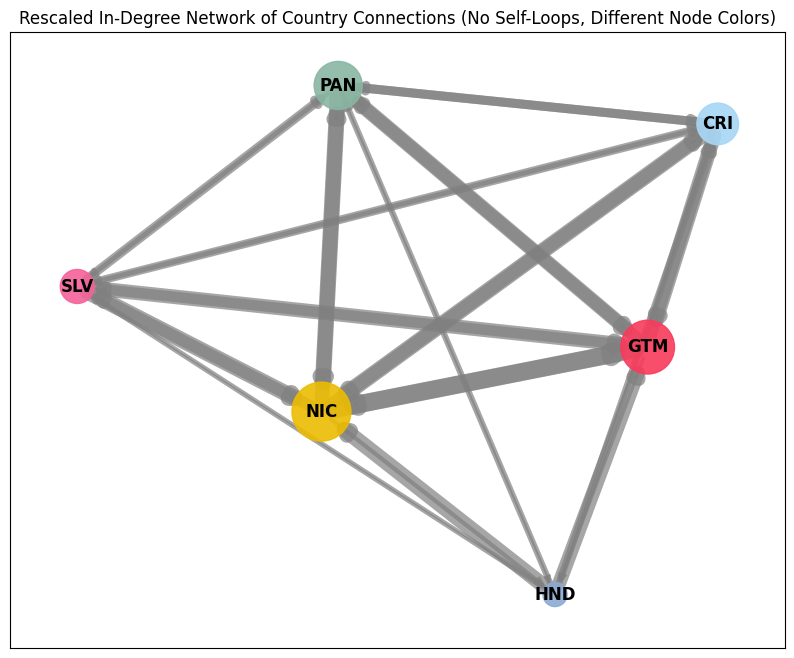

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

# 📌 Load the country connections matrix
drive_path = "/content/drive/MyDrive/Thesis/thesis/Paper input output/data/real/CA IO table 2014 - real.xlsx"
country_connections = pd.read_excel(drive_path, sheet_name="Country_Connections", index_col=0)

# 📌 Compute node weights (In-Degree) with higher scaling
column_sums = country_connections.sum(axis=0).sort_values()
scaling_factor = 1.0  # Increased scaling factor for better visibility
node_ranks = {country: i for i, country in enumerate(column_sums.index)}
node_sizes = {country: 300 + node_ranks[country] * scaling_factor * 300 for country in column_sums.index}  # Increase base size

# 📌 Generate random colors for nodes
node_colors = {country: "#%06x" % random.randint(0, 0xFFFFFF) for country in column_sums.index}

# 📌 Create the graph
graph = nx.DiGraph()
for country in country_connections.index:
    graph.add_node(country, size=node_sizes[country], color=node_colors[country])

# 📌 Compute edge weights with scaling and omit self-loops
edge_weights = []
edge_values = country_connections[country_connections > 0].values.flatten()
edge_values = edge_values[~np.isnan(edge_values)]  # Remove NaN
edge_values.sort()
edge_ranks = {value: i for i, value in enumerate(np.unique(edge_values))}

edge_scaling_factor = 0.5  # Base increment for edge thickness
base_edge_width = 1  # Minimum edge thickness

for i, country1 in enumerate(country_connections.index):
    for j, country2 in enumerate(country_connections.columns):
        if country1 != country2 and country_connections.at[country1, country2] > 0:
            weight = country_connections.at[country1, country2]
            edge_width = base_edge_width + edge_ranks[weight] * edge_scaling_factor
            graph.add_edge(country1, country2, weight=edge_width)
            edge_weights.append(edge_width)

# 📌 Draw the network
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(graph, seed=42)  # Node positioning

# Draw nodes
node_sizes_list = [graph.nodes[n]["size"] for n in graph.nodes]
node_color_list = [graph.nodes[n]["color"] for n in graph.nodes]
nx.draw_networkx_nodes(graph, pos, node_size=node_sizes_list, node_color=node_color_list, alpha=0.9)

# Draw edges
edges = graph.edges(data=True)
edge_widths = [d["weight"] for (_, _, d) in edges]
nx.draw_networkx_edges(graph, pos, width=edge_widths, edge_color="gray", alpha=0.7)

# Draw node labels
nx.draw_networkx_labels(graph, pos, font_size=12, font_weight="bold")

plt.title("Rescaled In-Degree Network of Country Connections (No Self-Loops, Different Node Colors)")
plt.show()











Step #7: This code generates a directed network visualization based on the out-degree connectivity of country connections, using a rescaled approach for better interpretability. The primary dataset used is the Country_Connections matrix, which quantifies linkages between different countries.



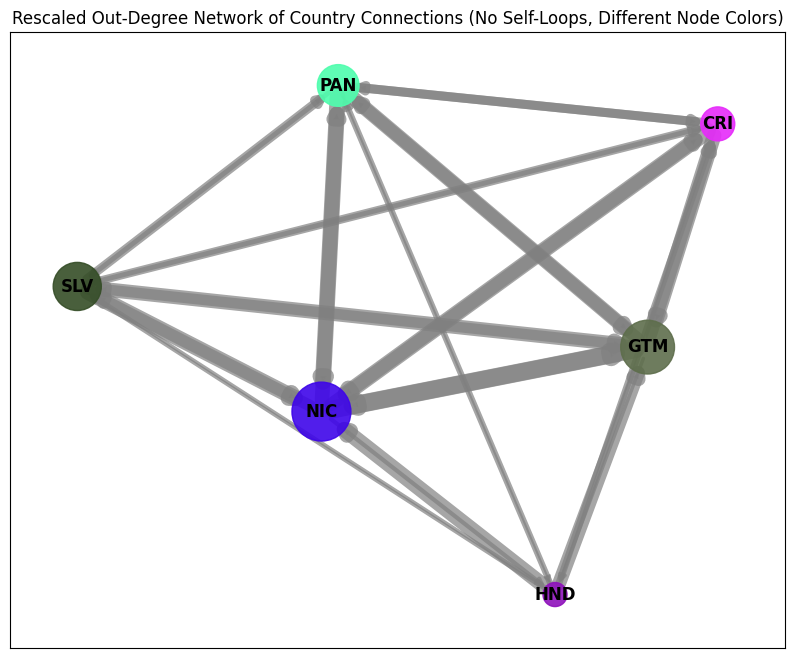

In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

# 📌 Load the country connections matrix
drive_path = "/content/drive/MyDrive/Thesis/thesis/Paper input output/data/real/CA IO table 2014 - real.xlsx"
country_connections = pd.read_excel(drive_path, sheet_name="Country_Connections", index_col=0)

# 📌 Compute node weights (Out-Degree) with higher scaling
row_sums = country_connections.sum(axis=1).sort_values()
scaling_factor = 1.0  # Increased scaling factor for better visibility
node_ranks = {country: i for i, country in enumerate(row_sums.index)}
node_sizes = {country: 300 + node_ranks[country] * scaling_factor * 300 for country in row_sums.index}  # Increase base size

# 📌 Generate random colors for nodes
node_colors = {country: "#%06x" % random.randint(0, 0xFFFFFF) for country in row_sums.index}

# 📌 Create the graph
graph = nx.DiGraph()
for country in country_connections.index:
    graph.add_node(country, size=node_sizes[country], color=node_colors[country])

# 📌 Compute edge weights with scaling and omit self-loops
edge_weights = []
edge_values = country_connections[country_connections > 0].values.flatten()
edge_values = edge_values[~np.isnan(edge_values)]  # Remove NaN
edge_values.sort()
edge_ranks = {value: i for i, value in enumerate(np.unique(edge_values))}

edge_scaling_factor = 0.5  # Base increment for edge thickness
base_edge_width = 1  # Minimum edge thickness

for i, country1 in enumerate(country_connections.index):
    for j, country2 in enumerate(country_connections.columns):
        if country1 != country2 and country_connections.at[country1, country2] > 0:
            weight = country_connections.at[country1, country2]
            edge_width = base_edge_width + edge_ranks[weight] * edge_scaling_factor
            graph.add_edge(country1, country2, weight=edge_width)
            edge_weights.append(edge_width)

# 📌 Draw the network
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(graph, seed=42)  # Node positioning

# Draw nodes
node_sizes_list = [graph.nodes[n]["size"] for n in graph.nodes]
node_color_list = [graph.nodes[n]["color"] for n in graph.nodes]
nx.draw_networkx_nodes(graph, pos, node_size=node_sizes_list, node_color=node_color_list, alpha=0.9)

# Draw edges
edges = graph.edges(data=True)
edge_widths = [d["weight"] for (_, _, d) in edges]
nx.draw_networkx_edges(graph, pos, width=edge_widths, edge_color="gray", alpha=0.7)

# Draw node labels
nx.draw_networkx_labels(graph, pos, font_size=12, font_weight="bold")

plt.title("Rescaled Out-Degree Network of Country Connections (No Self-Loops, Different Node Colors)")
plt.show()


Step #8: This code analyzes the degree distribution of sectors in a regional trade network using the binary adjacency matrix of GVAN. It calculates key network metrics (In-Degree, Out-Degree, and Total Degree) and visualizes their distributions to understand sectoral connectivity.

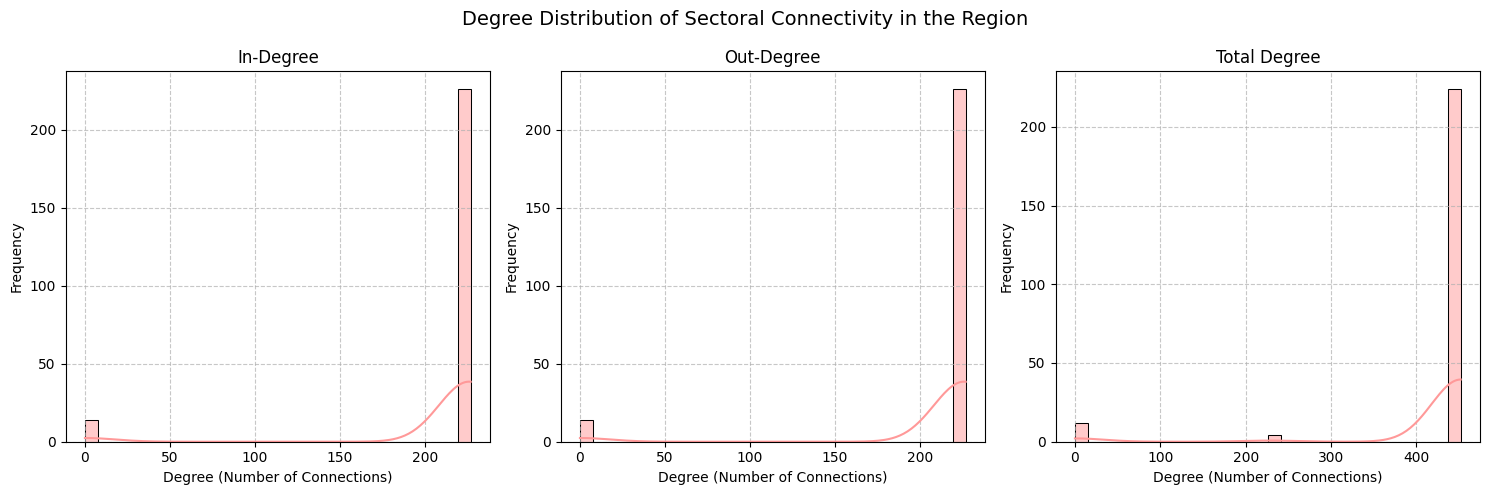

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 📌 Load the Binary Adjacency Matrix of GVAN
drive_path = "/content/drive/MyDrive/Thesis/thesis/Paper input output/data/real/CA IO table 2014 - real.xlsx"
binary_gvan_matrix = pd.read_excel(drive_path, sheet_name="Binary_Adjacency_GVAN", index_col=0)

# 📌 Compute In-Degree, Out-Degree, and Total Degree using the binary adjacency matrix
in_degree = binary_gvan_matrix.sum(axis=0)  # Sum of columns (who receives connections)
out_degree = binary_gvan_matrix.sum(axis=1)  # Sum of rows (who sends connections)
total_degree = in_degree + out_degree  # Total connectivity per sector

# 📌 Plot degree distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
degree_labels = ["In-Degree", "Out-Degree", "Total Degree"]
degree_data = [in_degree, out_degree, total_degree]

for i, (degree, label) in enumerate(zip(degree_data, degree_labels)):
    ax = axes[i]
    sns.histplot(degree, bins=30, kde=True, color="#ff9999", edgecolor="black", ax=ax)
    ax.set_title(label)
    ax.set_xlabel("Degree (Number of Connections)")
    ax.set_ylabel("Frequency")
    ax.grid(True, linestyle="--", alpha=0.7)

plt.suptitle("Degree Distribution of Sectoral Connectivity in the Region", fontsize=14)
plt.tight_layout()
plt.show()



Step #9: This code analyzes the degree distribution of sectors in a regional trade network, categorizing them by country. It generates separate In-Degree and Out-Degree histograms for each country using Seaborn's FacetGrid.

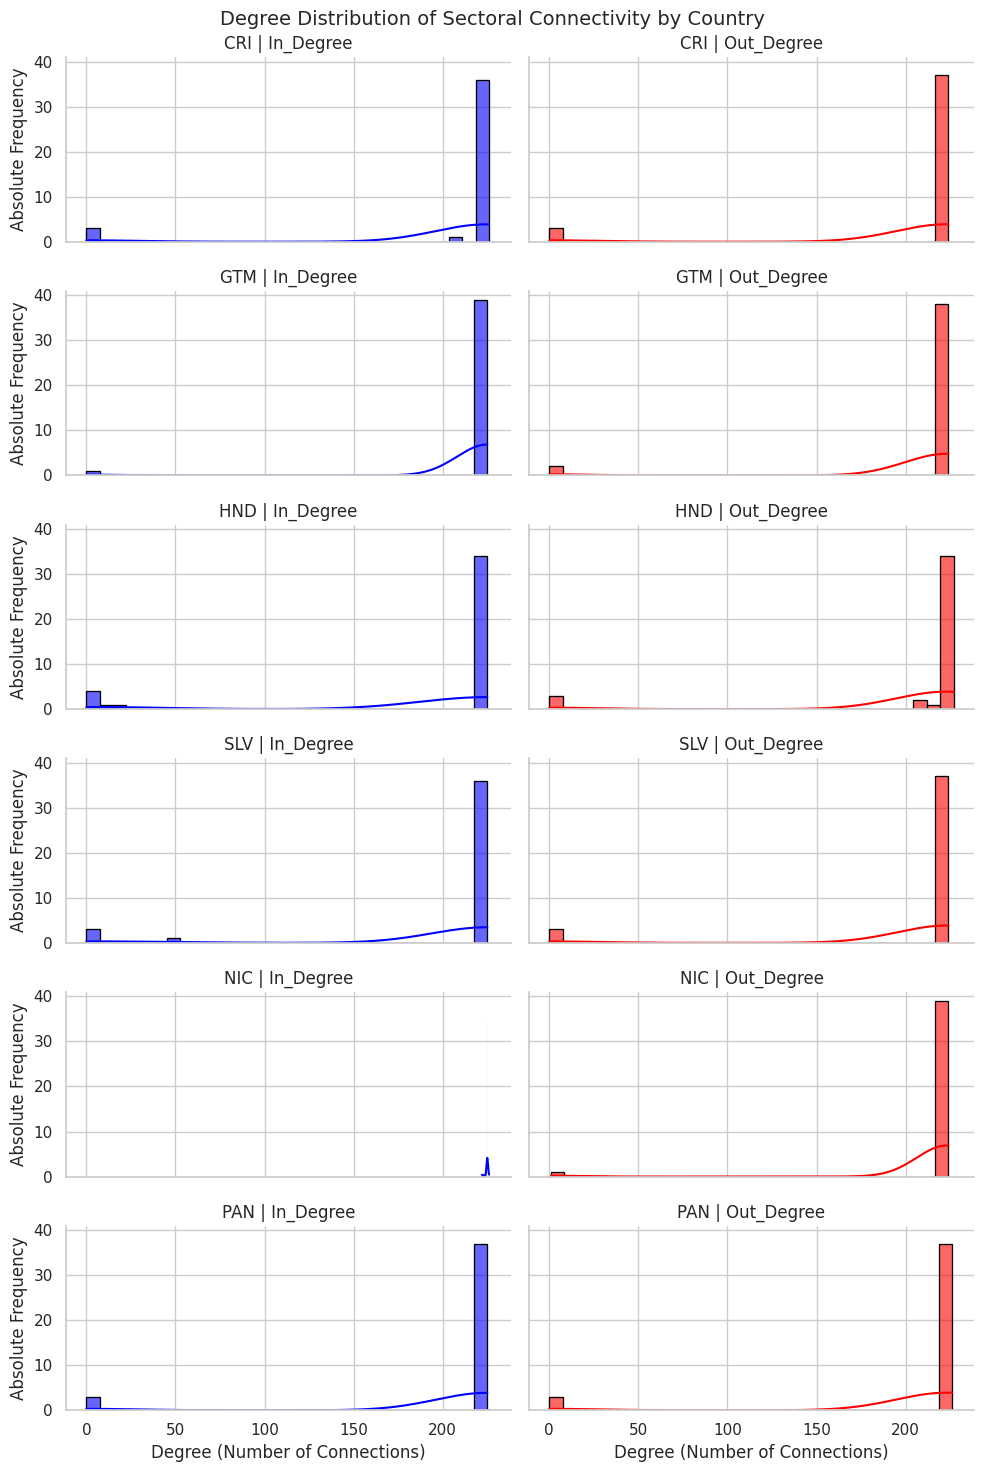

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 📌 Load the Degree In-Out Data by Sector
drive_path = "/content/drive/MyDrive/Thesis/thesis/Paper input output/data/real/CA IO table 2014 - real.xlsx"
degree_data = pd.read_excel(drive_path, sheet_name="Degree_In_Out_Sec")

# 📌 Extract country codes from sector nodes
degree_data["Country"] = degree_data["nodes"].str[:3]  # Extract first three letters

# 📌 Set plot style
sns.set(style="whitegrid")

# 📌 Define color mapping for degree types
degree_colors = {"In_Degree": "blue", "Out_Degree": "red"}

# 📌 Create a 2-column FacetGrid for In-Degree and Out-Degree per country
g = sns.FacetGrid(degree_data.melt(id_vars=["nodes", "Country"], value_vars=["In_Degree", "Out_Degree"],
                                   var_name="Degree Type", value_name="Degree"),
                  col="Degree Type", row="Country", height=2.5, aspect=2, sharex=True, sharey=True)
g.map_dataframe(sns.histplot, x="Degree", bins=30, kde=True, edgecolor="black", alpha=0.6,
                hue="Degree Type", palette=degree_colors, legend=False)

g.set_axis_labels("Degree (Number of Connections)", "Absolute Frequency")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
plt.suptitle("Degree Distribution of Sectoral Connectivity by Country", fontsize=14)
plt.tight_layout()
plt.show()



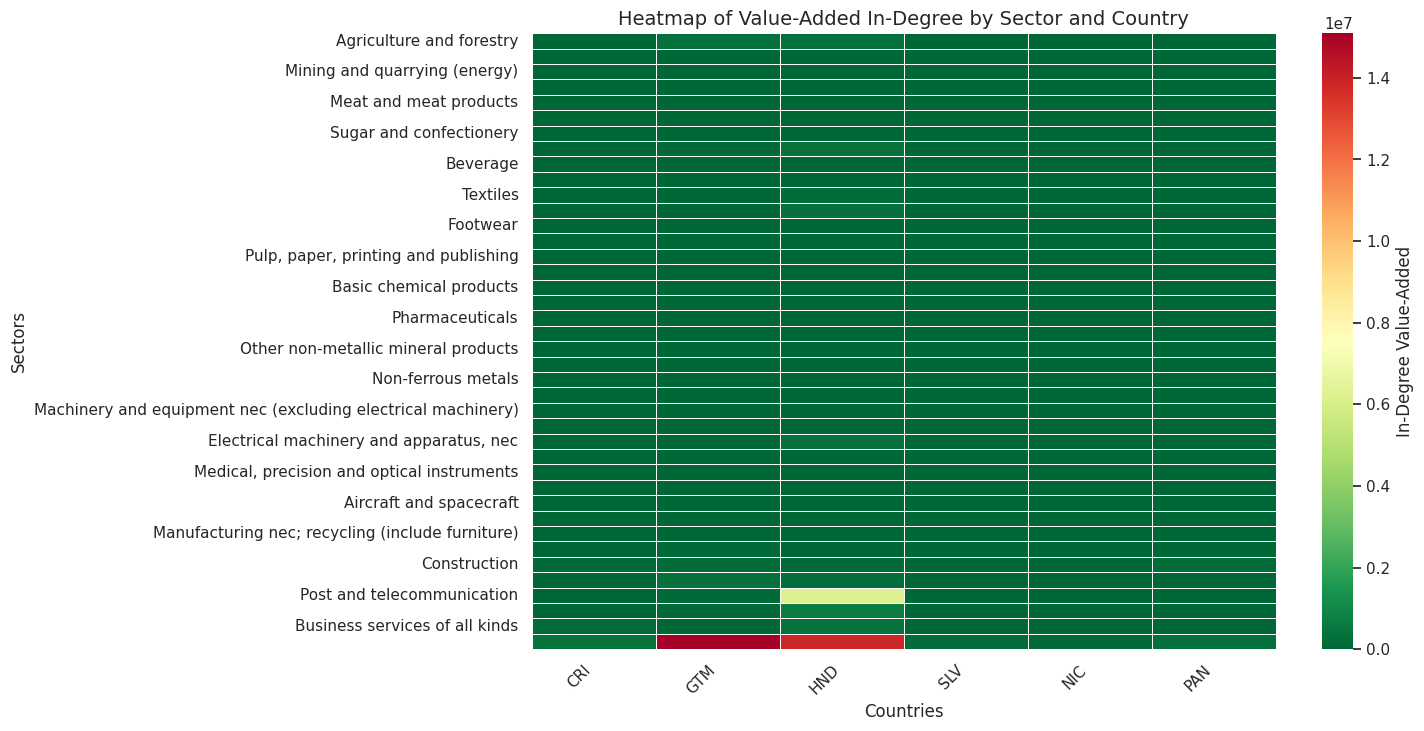

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 📌 Load the In-Degree Heatmap Data from Google Sheets
drive_path = "/content/drive/MyDrive/Thesis/thesis/Paper input output/data/real/CA IO table 2014 - real.xlsx"
in_degree_data = pd.read_excel(drive_path, sheet_name="Heatmap_GVAN_In_Degree", index_col=0)

# 📌 Normalize the data for better color scaling
min_value = in_degree_data.replace(0, np.nan).min().min()  # Avoid 0 affecting scale
max_value = in_degree_data.max().max()

# 📌 Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(in_degree_data, cmap="RdYlGn_r", annot=False, fmt=".1f", linewidths=0.5,
            cbar_kws={"label": "In-Degree Value-Added"}, vmin=min_value, vmax=max_value)
plt.xticks(rotation=45, ha='right')  # Rotate country labels for better readability
plt.yticks(rotation=0)  # Keep sector labels horizontal
plt.title("Heatmap of Value-Added In-Degree by Sector and Country", fontsize=14)
plt.xlabel("Countries", fontsize=12)
plt.ylabel("Sectors", fontsize=12)
plt.show()




